# **Proyecto NLP - Deteccion de tweets con contenido de tipo racista/sexista**

En el presente proyecto se utilizará un dataset que consta de tweets en idioma inglés con una etiqueta 0 / 1 que indica si un tweet es racista/sexista (1) o su temática no lo es (0)

Se proponen 2 modelos para determinar la etiqueta de un tweet a partir de las palabras que lo conforman: Clasificador Bayesiano y LSTM

Link al dataset: <a href="https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech/version/1?select=train.csv">Kaggle-Twitter</a>

*Podrá encontrar este proyecto junto con otros de ML en mi <a href="https://github.com/christianwes/proyectos_machine_learning">Github</a>*



## 1) Paquetes
Las siguientes celdas instalan el paquete wordcloud y descargaremos los datos que utilizaremos de la librería nltk.

In [1]:
!python -m pip install wordcloud

In [2]:
!python -m nltk.downloader all

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nlt

In [3]:
#Importamos las librerias necesarias
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from wordcloud import WordCloud,STOPWORDS
from subprocess import check_output
from sklearn.model_selection import train_test_split

%matplotlib inline

# 2) Dataset a utilizar

Subiremos el dataset y lo trabajaremos como un dataframe mediante la libreria pandas

In [5]:
df = pd.read_csv('tweets.csv')

In [6]:
# Tamaño del dataframe
df.shape 

(31962, 3)

In [7]:
# Por fines demostrativos y reduccion del tiempo  de procesamiento, nos limitaremos a utilizar 5000 filas únicamente
df=df.iloc[:5000]

In [8]:
# Revisamos las dimensiones del dataset.
df.shape

(5000, 3)

In [9]:
#Analizamos 10 resgistros del dataset
df.sample(10)

,id,label,tweet
3842,3843,0,@user @user whoohoo! congrats! well deserved! ...
3611,3612,0,more depressing scenes from the euros. don't s...
3891,3892,0,can only imagine hope &amp; anxiousness each t...
3371,3372,0,out of office #coffee #sun @ maspalomas
345,346,0,happy father's day 2016 to my dad and all of t...
1154,1155,0,"oh that's #lovely @user #healthy day to you,..."
4802,4803,0,the sad moment when you walk into a bookstore ...
4402,4403,0,had a good girls night with my two fav's at st...
2297,2298,0,i lost my 4.0 ð© #day
798,799,0,signed up for my first bikram yoga classâºï¸


In [10]:
# Unicamente utilizaremos las columnas label y tweet. Descarto el campo id
df = df[['tweet','label']]

In [11]:
#Analizamos si hay valores nulos
df.isna().sum()

tweet    0
label    0
dtype: int64

Separaremos a continuación parte de los datos en dos set de datos: train y test (función train_test_split), reservando un 15% de los datos  para testear los modelos.

In [12]:
train, test = train_test_split(df,test_size = 0.15)

# 3) Visualización
Haremos uso del paquete wordcloud para generar una nube de palabras. Primeramente limpiaremos los datos y los dividiremos segun sus etiquetas.


In [13]:
train

,tweet,label
508,@user unreal 3 advisors refuse to take my paym...,0
1400,@user pay of #rich #white #snobs via @user #...,1
2055,people complain about power supply in their ar...,0
1665,please wait for me!!! #likeit #followback #bma...,0
3639,that's how we feel! two weeks until miss illin...,0
...,...,...
227,my friend just got engaged ð©ââ¤ï¸âð...,0
974,@user omg bitch ðððð i knew you w...,0
1585,why they have to grow up!!! #cute,0
1965,"good to see #england ""fans"" making us all feel...",0


In [14]:
df_train_1 = train[ train['label'] == 1]
df_train_1 = df_train_1['tweet']
df_train_0 = train[ train['label'] == 0]
df_train_0 = df_train_0['tweet']

df_test_1 = test[ test['label'] == 1]
df_test_1 = df_test_1['tweet']
df_test_0 = test[ test['label'] == 0]
df_test_0 = df_test_0['tweet']

In [15]:
# Ejemplo
df_train_0

508     @user unreal 3 advisors refuse to take my paym...
2055    people complain about power supply in their ar...
1665    please wait for me!!! #likeit #followback #bma...
3639    that's how we feel! two weeks until miss illin...
2240     feeling like a cat on a hot tin roof right now  
                              ...                        
227     my friend just got engaged  ð©ââ¤ï¸âð...
974      @user omg bitch ðððð i knew you w...
1585                 why they have to grow up!!! #cute   
1965    good to see #england "fans" making us all feel...
1159    daily #affirmation #motivation #inspiration #p...
Name: tweet, Length: 3963, dtype: object

Palabras relacionadas con racismo/sexismo


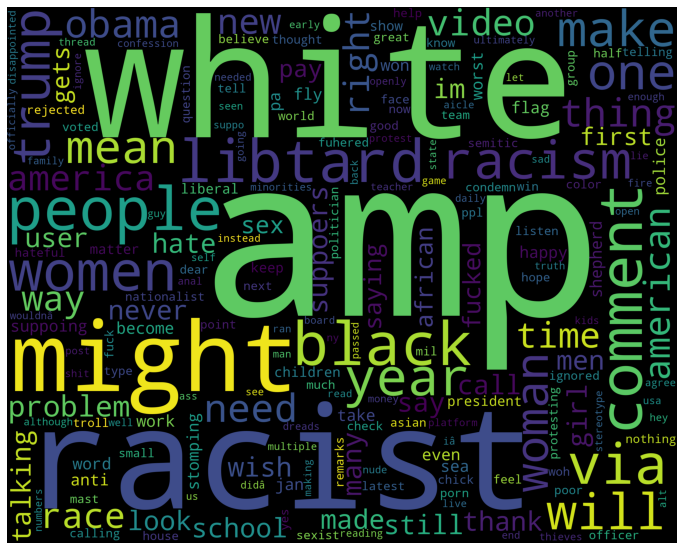

Palabras no relacionadas con racismo/sexismo


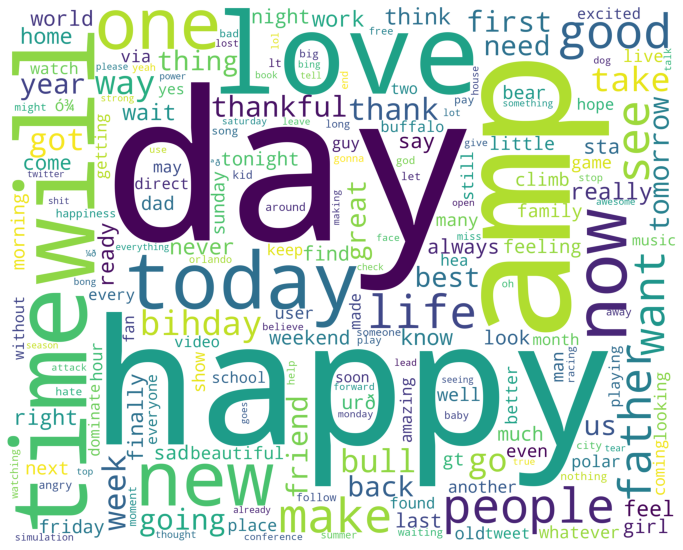

In [16]:
#Generamos una nube de palabras y se eliminan palabras que inicien con simbolos que hacen referencia a hashtags , menciones o links y retweets.
def nube_de_palabras(data, color = 'white'):
    words = ' '.join(data)
    ''' 
    '''
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          collocations=False,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(12, 12))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Palabras relacionadas con racismo/sexismo")
nube_de_palabras(df_train_1,'black')
print("Palabras no relacionadas con racismo/sexismo")
nube_de_palabras(df_train_0)

In [17]:
#Ejemplos:  
#df_train_1[156]

In [18]:
#df_train_0[64]

# 4) Limpieza dataset
Sabiendo que son tweets podemos proponernos remover remover links, menciones, hashtags, stopwords del dataset (similar a lo realizado para la nube de palabras)

In [19]:
#Palabras a minúsculas
df['tweet'] = df['tweet'].apply(lambda x: x.lower())

In [20]:
#Elimina todos los caracteres no alfanuméricos
df['tweet'] = df['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [21]:
#Elimina referencias a retweets (identificados por 'rt', reemplazados por espacio)
for idx,row in df.iterrows():
    row[0] = row[0].replace('rt',' ')

In [22]:
# Armamos una funcion, la cual al pasarle un dataset, ejecuta varias acciones de limpieza
def acciones(dataset):
    tweets = []
    #Utilizamos una lista de stopwords de ingles
    stopwords_set = set(stopwords.words("english"))
    #Iteracion
    for index, row in dataset.iterrows():
        #Filtro para palabras muy cortas y transforma a minúscula
        words_filtered = [e.lower() for e in row.tweet.split() if len(e) >= 3]
        #Filtros generales
        words_cleaned = [word for word in words_filtered
            if 'http' not in word
            and not word.startswith('@')
            and not word.startswith('#') 
            and not word.startswith('ð')
            and not word.startswith('â')
            and word != 'RT']
        
        words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
        #Se une todo en un mismo vector
        tweets.append((words_without_stopwords,row.label))
    return tweets


In [23]:
#Pasamos la funcion por los datasets de train y test
tweets_train = acciones(train)
tweets_test = acciones(test)

In [24]:
# Analizamos la cantidad de tweets de cada etiqueta
print(df[ df['label'] == 0].size)
print(df[ df['label'] == 1].size)

9318
682


In [25]:
#Miremos un ejemplo del resultado posterior a la limpieza
tweets_train[502]

(['lay', 'holiday', 'cloths'], 0)

# **1do Modelo - Clasificador Bayesiano Ingenuo**


Uniremos todas las palabras en una única lista (aun si están repetidas) para luego contar la frecuencia de aparición de cada una

In [26]:
# Funcion para listar palabras
def listado(tweets):
    all = []
    for (tweet, label) in tweets:
        all.extend(tweet)
    return all

palabras_unidas = listado(tweets_train)

In [27]:
# Veamos el resultado
palabras_unidas

['unreal',
 'advisors',
 'refuse',
 'take',
 'payment!??',
 'say',
 'wait',
 'pcn',
 'customer',
 'service',
 'site',
 'wasnt',
 'working??',
 'pay',
 'via',
 'people',
 'complain',
 'power',
 'supply',
 'area..am',
 'happy',
 'say',
 'enjoy',
 'light',
 'area..kudos',
 'phed...20hrs',
 'day',
 'light..',
 'please',
 'wait',
 'me!!!',
 "that's",
 'feel!',
 'two',
 'weeks',
 'miss',
 'illinois',
 'miss',
 'indiana!',
 'feeling',
 'like',
 'cat',
 'hot',
 'tin',
 'roof',
 'right',
 'first',
 'week',
 'school',
 'success',
 'though',
 'it,',
 'did!',
 'thank',
 'lord!',
 'settling',
 'final',
 'stage',
 'criterium',
 'dauphine',
 '2016',
 'itv',
 'hub.',
 'sunday',
 'funday!!',
 'internet',
 'works',
 'again!',
 "let's",
 'record',
 'videos',
 'hope',
 'also',
 'upload',
 'video',
 'tommorrow,',
 'thanks',
 'patienceâ\x99¥',
 'families',
 'killed',
 '&amp;',
 'injured',
 'orlando,',
 'florida.',
 'horrific',
 'attack',
 'innocent',
 'people.',
 'unbelievably',
 '11:11',
 'healthy',
 'fam'

A partir de la lista palabras_unidas podemos calcular la frecuencia de aparición de cada una de las palabras usando la función nltk.FreqDist .

In [28]:
def frecuencia_de_palabras(lista_completa):
    palabras_freq = nltk.FreqDist(lista_completa)
    return palabras_freq

frecuencia = frecuencia_de_palabras(palabras_unidas)

In [29]:
# Listamos cantidad de apariciones de cada palabra ordenadas
frecuencia = sorted(frecuencia.items(), key=lambda x:x[1])
frecuencia = dict(frecuencia)
frecuencia

{'unreal': 1,
 'advisors': 1,
 'refuse': 1,
 'payment!??': 1,
 'pcn': 1,
 'wasnt': 1,
 'working??': 1,
 'complain': 1,
 'supply': 1,
 'area..am': 1,
 'area..kudos': 1,
 'phed...20hrs': 1,
 'light..': 1,
 'feel!': 1,
 'illinois': 1,
 'indiana!': 1,
 'tin': 1,
 'did!': 1,
 'lord!': 1,
 'settling': 1,
 'criterium': 1,
 'dauphine': 1,
 'itv': 1,
 'hub.': 1,
 'funday!!': 1,
 'record': 1,
 'tommorrow,': 1,
 'patienceâ\x99¥': 1,
 'orlando,': 1,
 'florida.': 1,
 'unbelievably': 1,
 '11:11': 1,
 'greenwood,': 1,
 'tulsa,': 1,
 'tulsa': 1,
 'acknowledge': 1,
 'massacre.': 1,
 'teens': 1,
 're-branded': 1,
 'bracelets...': 1,
 'homework': 1,
 'inhumane': 1,
 'mfs': 1,
 "y'all,": 1,
 'plants': 1,
 'gardening': 1,
 'how!': 1,
 'cardsâ\x80¦': 1,
 'summerð\x9f\x91\x8d!': 1,
 'acts': 1,
 'cowards.': 1,
 'murder': 1,
 'answer.': 1,
 'adveised': 1,
 'thanx': 1,
 'cute.#i_am': 1,
 'intelligence': 1,
 'agencies': 1,
 'have...': 1,
 'intelligence,': 1,
 'so.': 1,
 'aaaaand': 1,
 'sorry?': 1,
 'sorry??': 1,

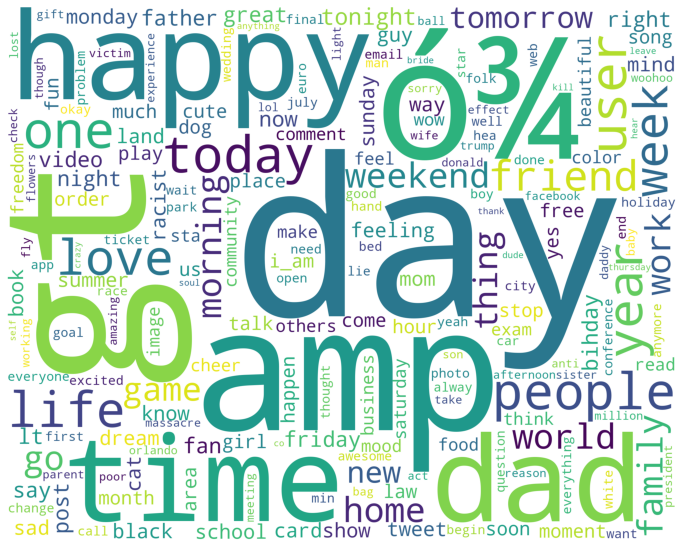

In [30]:
nube_de_palabras(frecuencia.keys())

Definimos un extractor de features donde verificamos si una palabra está presente en un documento

In [31]:
def extraer_caracteristicas(documento): 
    documento_palabras = set(documento)
    caracteristicas = {}
    for palabra in frecuencia:
        caracteristicas['existe(%s)' % palabra] = (palabra in documento_palabras)
    return caracteristicas

Utilizamos la función nltk.classify.apply_features que retorna un objeto que actúa como una lista pero consume menos memoria. 

Utilizaremos esta función y luego entrenaremos nuestro clasificador bayesiano ingenuo.

In [32]:
# Entrenamiento 
training_set = nltk.classify.apply_features(extraer_caracteristicas,tweets_train)
clasificador = nltk.NaiveBayesClassifier.train(training_set)

### 5) Resultados

In [33]:
clasificador.show_most_informative_features(5)

Most Informative Features
          existe(racist) = True                1 : 0      =     68.8 : 1.0
        existe(comments) = True                1 : 0      =     68.8 : 1.0
          existe(racism) = True                1 : 0      =     59.6 : 1.0
            existe(race) = True                1 : 0      =     50.5 : 1.0
           existe(obama) = True                1 : 0      =     50.5 : 1.0


Lectura de resultados:
contiene(racist,) = True           Positi : Negati =     76.3 : 1.0

Es decir, tweets con la palabra racist tienen 76.3 más posibilidades de ser racistas/sexistas que de no serlo.

Debido a limitaciones en la RAM calcularemos el accuracy únicamente sobre 1000 tweets del dataset de training.


In [34]:
print(nltk.classify.accuracy(clasificador, training_set[0:1000]))

0.945


Determinamos la precisión (accuracy) en los datos de test:

In [35]:
test_set = nltk.classify.apply_features(extraer_caracteristicas,tweets_test[0:1000])
print(nltk.classify.accuracy(clasificador, test_set))

0.9293333333333333


# **2do Modelo - LSTM**

Analizaremos el mismo caso de analisis de racismo/sexismo sobre los Tweets partiendo del dataset inicial luego de la limpieza, pero usando un enfoque distinto:  redes neuronales del tipo LSTM.

In [36]:
#Importamos las librerias adicionales para esta seccion

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout

### 1) Tokenización

Utilizamos el Tokenizer para vectorizar y convertir el texto en secuencias ya que es el input necesario para la red. Usamos un máximo de 1500 features.

In [37]:
max_features = 1500

#Inicializamos el Tokenizer
tokenizer = Tokenizer(num_words=max_features, split=' ')
#Entrenamiento
tokenizer.fit_on_texts(df['tweet'].values)
#texts_to_sequences transforma el input en arrays numéricos
X = tokenizer.texts_to_sequences(df['tweet'].values)
#pads_sequences transforma las secuencias al mismo largo
X = pad_sequences(X)

### 2) Armado de red neuronal

Se configuran parametros habituales para este tipo de modelo

In [38]:
embed_dim = 115
lstm_out = 175

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.4))
model.add(LSTM(lstm_out, dropout=0.15, recurrent_dropout=0.15))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 29, 115)           172500    
                                                                 
 dropout (Dropout)           (None, 29, 115)           0         
                                                                 
 lstm (LSTM)                 (None, 175)               203700    
                                                                 
 dense (Dense)               (None, 2)                 352       
                                                                 
Total params: 376,552
Trainable params: 376,552
Non-trainable params: 0
_________________________________________________________________


### 3)Entrenamiento
La función de pérdida utilizada es categorical_crossentropy

In [39]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

Preparamos los datos para el entrenamiento (partimos del dataset original filtrado)

In [40]:
Y = pd.get_dummies(df['label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 38)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3750, 29) (3750, 2)
(1250, 29) (1250, 2)


Entrenamos el modelo con un batch size y cantidad de epochs determinada

In [ ]:
batch_size = 24
model.fit(X_train, Y_train, epochs = 8, batch_size=batch_size, verbose = 2)

Epoch 1/8
157/157 - 23s - loss: 0.2626 - accuracy: 0.9277 - 23s/epoch - 149ms/step
Epoch 2/8


### 4) Resultados

In [ ]:
#Tomo 150 datos para la validación y test
validacion_tamaño = 150

X_validacion = X_test[-validacion_tamaño:]
Y_validacion= Y_test[-validacion_tamaño:]
X_test = X_test[:-validacion_tamaño]
Y_test = Y_test[:-validacion_tamaño]

In [ ]:
print(X_test.shape,Y_test.shape)
print(X_validacion.shape,Y_validacion.shape)

In [ ]:
score,accuracy = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("Score: %.2f" % (score))
print("Accuracy: %.2f" % (accuracy))

Utilizamos el método predict para verificar si el comportamiento con los tweets de contenido racista/sexista (1) es el mismo que con no lo son (0) o si hay un sesgo en los datos.

In [ ]:
# Seteamos las variables del ciclo for en 0 antes de correr la celda
total_unos, total_ceros, unos, ceros = 0, 0, 0, 0
for x in range(len(X_validacion)):
    
    result = model.predict(X_validacion[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 0)[0]
   
    if np.argmax(result) == np.argmax(Y_validacion[x]):
        if np.argmax(Y_validacion[x]) == 1:
            unos = unos + 1
        else:
            ceros = ceros + 1
       
    if np.argmax(Y_validacion[x]) == 1:
        total_unos = total_unos + 1
    else:
        total_ceros = total_ceros + 1

print("Proporcion de tweets racistas/sexistas", unos/total_unos*100, "%")
print("Proporcion de tweets sin contenido racista/sexista", ceros/total_ceros*100, "%")

# Conclusiones 

El accuracy alcanzado sobre el set de testeo con el modelo LSTM es similar al obtenido con el modelo de Bayes. Esto puede deberse a que se entrenó el modelo LSTM con pocos datos y pocos epochs (demandaria mas tiempo y un dataset mas grande). Ademas, se recomienda balancear el dataset ya que hay muchos tweets etiquetados como 1 por sobre los etiquetados como 0, lo que puede provocar una tendencia a que el modelo infiera con mayor facilidad que un tweet nuevo que se analiza le corresponde la etiqueta 1.